**Mount Google Drive and unzip the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/CASCADE-master.zip

Archive:  /content/drive/MyDrive/CASCADE-master.zip
   creating: CASCADE-master/
  inflating: __MACOSX/._CASCADE-master  
  inflating: CASCADE-master/CASCADE_presentation_ppt_final.pdf  
  inflating: __MACOSX/CASCADE-master/._CASCADE_presentation_ppt_final.pdf  
  inflating: CASCADE-master/.DS_Store  
  inflating: __MACOSX/CASCADE-master/._.DS_Store  
  inflating: CASCADE-master/requirements.txt  
  inflating: __MACOSX/CASCADE-master/._requirements.txt  
  inflating: CASCADE-master/overall_model.jpg  
  inflating: __MACOSX/CASCADE-master/._overall_model.jpg  
  inflating: CASCADE-master/comments.json  
  inflating: __MACOSX/CASCADE-master/._comments.json  
  inflating: CASCADE-master/final_test_data-3.csv  
  inflating: __MACOSX/CASCADE-master/._final_test_data-3.csv  
  inflating: CASCADE-master/cca.jpg  
  inflating: __MACOSX/CASCADE-master/._cca.jpg  
  inflating: CASCADE-master/stylometric_embeddings_bert.csv  
  inflating: __MACOSX/CASCADE-master/._stylometric_embeddings_bert.csv 

**Data Preprocessing**

Clean and prepare comments data from JSON and CSV files for further analysis.

In [ ]:
import json
import numpy as np
import pandas as pd
from collections import defaultdict
import re

# Paths to your data files
comments_file_path = r"CASCADE-master/comments.json"
train_map_file = r"CASCADE-master/data/my_train_balanced.csv"
test_map_file = r"CASCADE-master/data/my_test_balanced.csv"
# Load comments.json
with open(comments_file_path, 'r') as f:
    comments = json.load(f)

def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

def build_data_cv(data_folder, comments, cv=10, clean_string=True):
    revs = []
    vocab = defaultdict(float)

    train_data = np.asarray(pd.read_csv(data_folder[0], header=None))
    test_data = np.asarray(pd.read_csv(data_folder[1], header=None))

    for line in train_data:
        comment_id = str(line[0])
        if comment_id in comments:
            rev = []
            label_str = line[2]
            label = [1, 0] if label_str == 0 else [0, 1]
            rev.append(comments[comment_id]['text'].strip())
            if clean_string:
                orig_rev = clean_str(" ".join(rev))
            else:
                orig_rev = " ".join(rev).lower()
            words = set(orig_rev.split())
            for word in words:
                vocab[word] += 1
            orig_rev = " ".join(orig_rev.split()[:100])
            datum = {
                "y": int(1),
                "id": comment_id,
                "text": orig_rev,
                "author": comments[comment_id]['author'],
                "topic": comments[comment_id]['subreddit'],
                "label": label,
                "num_words": len(orig_rev.split()),
                "split": int(1)
            }
            revs.append(datum)

    for line in test_data:
        comment_id = str(line[0])
        if comment_id in comments:
            rev = []
            label_str = line[2]
            label = [1, 0] if label_str == 0 else [0, 1]
            rev.append(comments[comment_id]['text'].strip())
            if clean_string:
                orig_rev = clean_str(" ".join(rev))
            else:
                orig_rev = " ".join(rev).lower()
            words = set(orig_rev.split())
            for word in words:
                vocab[word] += 1
            orig_rev = " ".join(orig_rev.split()[:100])
            datum = {
                "y": int(1),
                "id": comment_id,
                "text": orig_rev,
                "author": comments[comment_id]['author'],
                "topic": comments[comment_id]['subreddit'],
                "label": label,
                "num_words": len(orig_rev.split()),
                "split": int(0)
            }
            revs.append(datum)

    return revs, vocab

data_folder = [train_map_file, test_map_file]
revs, vocab = build_data_cv(data_folder, comments, cv=10, clean_string=True)

# Check the data
print(f"Number of sentences: {len(revs)}")
print(f"Vocab size: {len(vocab)}")


Number of sentences: 219368
Vocab size: 74408


**Stylometric embeddings generation**

Generate stylometric embeddings for user posts using the BERT model.

In [ ]:
import os
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch

# Paths to your data files
train_user_file = "CASCADE-master/users/train_user.csv"

# Load the user training data
train_user_data = pd.read_csv(train_user_file, header=None)

# Prepare the data for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class UserDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user_id = self.data.iloc[idx, 0]
        posts = self.data.iloc[idx, 1]
        encoding = self.tokenizer.encode_plus(
            posts,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,  # Ensure truncation
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'user_id': user_id,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Parameters for the BERT model
max_len = 512
batch_size = 8
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Create Dataset and DataLoader
dataset = UserDataset(train_user_data, tokenizer, max_len)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load the BERT model
model = BertModel.from_pretrained('bert-base-uncased')
model = model.to(device)

# Generate stylometric embeddings for each user
user_embeddings = {}

model.eval()
with torch.no_grad():
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        user_ids = batch['user_id']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

        for user_id, embedding in zip(user_ids, embeddings):
            user_embeddings[user_id] = embedding

# Save the stylometric embeddings to a file
stylometric_embeddings_file = "CASCADE-master/stylometric_embeddings_bert.csv"
with open(stylometric_embeddings_file, 'w') as f:
    for user_id, embedding in user_embeddings.items():
        f.write(f"{user_id},{','.join(map(str, embedding))}\n")

print(f"Stylometric embeddings saved to {stylometric_embeddings_file}")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please u

Stylometric embeddings saved to CASCADE-master/stylometric_embeddings_bert.csv


**Personality embeddings generation**

Generate personality embeddings from personality essays using BERT.

In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch

# Paths to your data files
personality_essay_file = "CASCADE-master/data/personality_essay.csv"

# Load the personality essay data with the correct encoding
personality_essay_data = pd.read_csv(personality_essay_file, encoding='ISO-8859-1')

# Prepare the data for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class PersonalityDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        essay = self.data.iloc[idx]['TEXT']  # Correct column name for essay text
        user_id = self.data.iloc[idx]['#AUTHID']  # Correct column name for user ID
        encoding = self.tokenizer.encode_plus(
            essay,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,  # Ensure the sequence is truncated to max_length
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'user_id': user_id,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Parameters for the BERT model
max_len = 512
batch_size = 8
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Create Dataset and DataLoader
dataset = PersonalityDataset(personality_essay_data, tokenizer, max_len)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load the BERT model
model = BertModel.from_pretrained('bert-base-uncased')
model = model.to(device)

# Generate personality embeddings for each user
personality_embeddings = {}

model.eval()
with torch.no_grad():
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        user_ids = batch['user_id']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

        for user_id, embedding in zip(user_ids, embeddings):
            personality_embeddings[user_id] = embedding  # No need for .item() since user_id is a string

# Save the personality embeddings to a file
personality_embeddings_file = "CASCADE-master/personality_embeddings.csv"
with open(personality_embeddings_file, 'w') as f:
    for user_id, embedding in personality_embeddings.items():
        f.write(f"{user_id},{','.join(map(str, embedding))}\n")

print(f"Personality embeddings saved to {personality_embeddings_file}")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please u

Personality embeddings saved to CASCADE-master/personality_embeddings.csv


**Generate Discourse Embeddings**

Generate topic-related discourse embeddings using BERTopic on Reddit data.

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np

# Paths to your data files
train_topics_file = "CASCADE-master/discourse/train_topics.csv"

# Load the topic training data
train_topics_data = pd.read_csv(train_topics_file, header=None)

# Prepare the data for BERTopic
documents = train_topics_data[1].tolist()
topic_ids = train_topics_data[0].tolist()

# Display a sample
print(f"Sample document: {documents[0]}")

# Initialize BERTopic model
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")
bertopic_model = BERTopic(vectorizer_model=vectorizer_model)

# Fit the BERTopic model
topics, probabilities = bertopic_model.fit_transform(documents)

# Ensure the lengths match
if len(topic_ids) != len(probabilities):
    raise ValueError("The number of topic IDs does not match the number of probabilities.")

# Map topic IDs to embeddings (probabilities are vectors of floats)
discourse_embeddings_dict = {topic_id: probabilities[idx] for idx, topic_id in enumerate(topic_ids)}

# Save the discourse embeddings to a file
discourse_embeddings_file = "CASCADE-master/discourse_embeddings.csv"
with open(discourse_embeddings_file, 'w') as f:
    for topic_id, embedding in discourse_embeddings_dict.items():
        f.write(f"{topic_id},{','.join(map(str, embedding.flatten()))}\n")

print(f"Discourse embeddings saved to {discourse_embeddings_file}")


Sample document: this flair suits me. <END> But Shuichi is already a girl! <END> Link her to the V3 spoiler megathread; she'll be hooked right in <END> He reacted like that because the anime isn't really considered to be good quality, at least not nearly as good as the game itself. <END> ... there are 10 Vita games? <END> Ngl I voted for Kirigiri on some local positions that had no other candidates and I didn't want to vote for the one listed. <END> They will get Siri to voice him <END> Brb orchestrating global conflict and mass suicides with this vid thanks <END> There's already an official discord... <END> Mikan, but I don't know how they would change it without making it so gory. <END> Lay down. <END> Kodaka is western? <END> Wow, thanks for the spoiler <END> And of course Seiko wears lewd panties. <END> You mean like how there was nothing more to Monomi? <END> Oh My God That is... well... Monokuma's voice is not exactly fitting, but the rest doesn't seem too bad. <END> "wtf Junko h

**Generate Content Embeddings**

Extract comment text and create content embeddings using BERT for both training and test sets

In [ ]:
import json
import pandas as pd

# Step 1: Load the Data
comments_file_path = r"CASCADE-master/comments.json"
train_map_file = r"CASCADE-master/data/my_train_balanced.csv"
test_map_file = r"CASCADE-master/data/my_test_balanced.csv"

# Load comments.json
with open(comments_file_path, 'r') as f:
    comments = json.load(f)

# Load the training and testing data
train_data = pd.read_csv(train_map_file, header=None, names=["comment_id", "related_comment_id", "label"])
test_data = pd.read_csv(test_map_file, header=None, names=["comment_id", "related_comment_id", "label"])

# Step 2: Extract Comment Texts
def get_comment_text(comment_id, comments_dict):
    return comments_dict.get(comment_id, {}).get("text", "")

# Step 3: Create New Datasets
def prepare_dataset(data, comments):
    texts = []
    labels = []
    for _, row in data.iterrows():
        comment_id = str(row["comment_id"])
        text = get_comment_text(comment_id, comments)
        if text:
            texts.append(text)
            labels.append(row["label"])
    return pd.DataFrame({"text": texts, "label": labels})

# Prepare the datasets
final_train_data = prepare_dataset(train_data, comments)
final_test_data = prepare_dataset(test_data, comments)

# Display a sample from the datasets
print("Sample from final_train_data:")
print(final_train_data.head())

print("\nSample from final_test_data:")
print(final_test_data.head())

# Save the final datasets to CSV files
final_train_data.to_csv("CASCADE-master/final_train_data.csv", index=False)
final_test_data.to_csv("CASCADE-master/final_test_data.csv", index=False)

print(f"Final train data saved to /content/CASCADE-master/final_train_data.csv")
print(f"Final test data saved to /content/CASCADE-master/final_test_data.csv")


Sample from final_train_data:
                                                text  label
0                      Religion must have the answer      1
1  It's obviously tracks from a giant water tract...      0
2  Wow...he smoked pot...oh lord hes such a horri...      1
3  Wow, his girlfriend is uhm... Ah fuck it, he's...      0
4  I think the government should track every morm...      0

Sample from final_test_data:
                                                text  label
0        Yes, cuz tax cuts will help those w/o jobs!      1
1        If cutting taxes fails... cut taxes harder.      0
2  Chalk it up to the ever-increasing cost of fre...      1
3  We're about to finally get affordable housing,...      0
4   oh wow I am so surprised I never saw this coming      1
Final train data saved to /content/CASCADE-master/final_train_data.csv
Final test data saved to /content/CASCADE-master/final_test_data.csv


In [ ]:
import os
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch

# Paths to your data files
train_data_file = "CASCADE-master/final_train.csv"
test_data_file = "CASCADE-master/final_test.csv"

# Load the training and testing data
train_data = pd.read_csv(train_data_file)
test_data = pd.read_csv(test_data_file)

# Check for missing values
print(f"Missing values in train data before cleaning: {train_data['text'].isnull().sum()}")
print(f"Missing values in test data before cleaning: {test_data['text'].isnull().sum()}")

# Drop rows with missing values
train_data = train_data.dropna(subset=['text'])
test_data = test_data.dropna(subset=['text'])

# Check again for any missing values
print(f"Missing values in train data after dropping: {train_data['text'].isnull().sum()}")
print(f"Missing values in test data after dropping: {test_data['text'].isnull().sum()}")

# If any NaNs still remain, fill them with a placeholder
train_data['text'] = train_data['text'].fillna("placeholder text")
test_data['text'] = test_data['text'].fillna("placeholder text")

# Validate no missing values remain
assert train_data['text'].isnull().sum() == 0, "There are still missing values in train data"
assert test_data['text'].isnull().sum() == 0, "There are still missing values in test data"

# Prepare the data for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class CommentDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,  # Ensure truncation
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Parameters for the BERT model
max_len = 512
batch_size = 8
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Create Dataset and DataLoader for train and test datasets
train_dataset = CommentDataset(train_data, tokenizer, max_len)
test_dataset = CommentDataset(test_data, tokenizer, max_len)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the BERT model
model = BertModel.from_pretrained('bert-base-uncased')
model = model.to(device)

# Function to generate embeddings
def generate_embeddings(dataloader, model, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

            embeddings.extend(pooled_output)
    return embeddings

# Generate content embeddings for training and testing data
train_content_embeddings = generate_embeddings(train_dataloader, model, device)
test_content_embeddings = generate_embeddings(test_dataloader, model, device)

# Save the content embeddings to files
train_content_embeddings_file = "CASCADE-master/train_content_embeddings.csv"
test_content_embeddings_file = "CASCADE-master/test_content_embeddings.csv"

# Save the embeddings along with the labels
train_data['embeddings'] = train_content_embeddings
test_data['embeddings'] = test_content_embeddings

train_data.to_csv(train_content_embeddings_file, index=False)
test_data.to_csv(test_content_embeddings_file, index=False)

print(f"Train content embeddings saved to {train_content_embeddings_file}")
print(f"Test content embeddings saved to {test_content_embeddings_file}")


Missing values in train data before cleaning: 2
Missing values in test data before cleaning: 2
Missing values in train data after dropping: 0
Missing values in test data after dropping: 0


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Train content embeddings saved to CASCADE-master/train_content_embeddings.csv
Test content embeddings saved to CASCADE-master/test_content_embeddings.csv


**Data Preprocessing of Embeddings**

Preprocess all embeddings (imputation and scaling) to ensure data consistency for modeling.

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Device configuration: Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Paths to your embedding files
stylometric_embeddings_file = "/content/CASCADE-master/stylometric_embeddings_bert.csv"
personality_embeddings_file = "/content/CASCADE-master/personality_embeddings_bert-2.csv"
discourse_embeddings_file = "/content/CASCADE-master/discourse/discourse_features/discourse.csv"
train_content_embeddings_file = "/content/CASCADE-master/train_content_embeddings.csv"
test_content_embeddings_file = "/content/CASCADE-master/test_content_embeddings.csv"



# Load embeddings
stylometric_embeddings = pd.read_csv(stylometric_embeddings_file, header=None)
personality_embeddings = pd.read_csv(personality_embeddings_file, header=None)
discourse_embeddings = pd.read_csv(discourse_embeddings_file, header=None)
train_content_embeddings = pd.read_csv(train_content_embeddings_file, header=None)
test_content_embeddings = pd.read_csv(test_content_embeddings_file, header=None)

# Convert all data to numeric, coercing errors to NaN (which we will then impute)
stylometric_embeddings = stylometric_embeddings.apply(pd.to_numeric, errors='coerce')
personality_embeddings = personality_embeddings.apply(pd.to_numeric, errors='coerce')
discourse_embeddings = discourse_embeddings.apply(pd.to_numeric, errors='coerce')
train_content_embeddings = train_content_embeddings.apply(pd.to_numeric, errors='coerce')
test_content_embeddings = test_content_embeddings.apply(pd.to_numeric, errors='coerce')

# Identify columns that are entirely NaN and drop them
stylometric_embeddings = stylometric_embeddings.dropna(axis=1, how='all')
personality_embeddings = personality_embeddings.dropna(axis=1, how='all')
discourse_embeddings = discourse_embeddings.dropna(axis=1, how='all')
train_content_embeddings = train_content_embeddings.dropna(axis=1, how='all')
test_content_embeddings = test_content_embeddings.dropna(axis=1, how='all')

# Impute missing values using the mean of each column
imputer = SimpleImputer(strategy='mean')
stylometric_embeddings = pd.DataFrame(imputer.fit_transform(stylometric_embeddings))
personality_embeddings = pd.DataFrame(imputer.fit_transform(personality_embeddings))
discourse_embeddings = pd.DataFrame(imputer.fit_transform(discourse_embeddings))
train_content_embeddings = pd.DataFrame(imputer.fit_transform(train_content_embeddings))
test_content_embeddings = pd.DataFrame(imputer.fit_transform(test_content_embeddings))

# Verify the shape of dataframes after imputation
print("Shapes after imputing missing values:")
print(stylometric_embeddings.shape)
print(personality_embeddings.shape)
print(discourse_embeddings.shape)
print(train_content_embeddings.shape)
print(test_content_embeddings.shape)


Shapes after imputing missing values:
(283591, 769)
(2468, 768)
(16327, 101)
(64665, 2)
(64665, 2)


**Autoencoder-Based Embedding Fusion**

Train an autoencoder to fuse stylometric, personality, discourse, and content embeddings into a unified representation.

In [ ]:

import pandas as pd
import numpy as np
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim

# Device configuration: Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Paths to your embedding files
stylometric_embeddings_file = "CASCADE-master/stylometric_embeddings_bert.csv.csv"
personality_embeddings_file = "CASCADE-master/personality_embeddings_bert-2.csv.csv"
discourse_embeddings_file = "CASCADE-master/discourse/discourse_features/discourse.csv"
train_content_embeddings_file = "CASCADE-master/train_content_embeddings.csv.csv"
test_content_embeddings_file = "CASCADE-master/test_content_embeddings.csv.csv"

# Load embeddings
stylometric_embeddings = pd.read_csv(stylometric_embeddings_file, header=None)
personality_embeddings = pd.read_csv(personality_embeddings_file, header=None)
discourse_embeddings = pd.read_csv(discourse_embeddings_file, header=None)
train_content_embeddings = pd.read_csv(train_content_embeddings_file, header=None)
test_content_embeddings = pd.read_csv(test_content_embeddings_file, header=None)

# Convert all data to numeric, coercing errors to NaN (which we will then impute)
stylometric_embeddings = stylometric_embeddings.apply(pd.to_numeric, errors='coerce')
personality_embeddings = personality_embeddings.apply(pd.to_numeric, errors='coerce')
discourse_embeddings = discourse_embeddings.apply(pd.to_numeric, errors='coerce')
train_content_embeddings = train_content_embeddings.apply(pd.to_numeric, errors='coerce')
test_content_embeddings = test_content_embeddings.apply(pd.to_numeric, errors='coerce')

# Identify columns that are entirely NaN and drop them
stylometric_embeddings = stylometric_embeddings.dropna(axis=1, how='all')
personality_embeddings = personality_embeddings.dropna(axis=1, how='all')
discourse_embeddings = discourse_embeddings.dropna(axis=1, how='all')
train_content_embeddings = train_content_embeddings.dropna(axis=1, how='all')
test_content_embeddings = test_content_embeddings.dropna(axis=1, how='all')

# Impute missing values using the mean of each column
imputer = SimpleImputer(strategy='mean')
stylometric_embeddings = pd.DataFrame(imputer.fit_transform(stylometric_embeddings))
personality_embeddings = pd.DataFrame(imputer.fit_transform(personality_embeddings))
discourse_embeddings = pd.DataFrame(imputer.fit_transform(discourse_embeddings))
train_content_embeddings = pd.DataFrame(imputer.fit_transform(train_content_embeddings))
test_content_embeddings = pd.DataFrame(imputer.fit_transform(test_content_embeddings))

# Ensure the same number of rows in each dataframe before concatenation
min_rows = min(len(stylometric_embeddings), len(personality_embeddings), len(discourse_embeddings), len(train_content_embeddings))
stylometric_embeddings = stylometric_embeddings.iloc[:min_rows]
personality_embeddings = personality_embeddings.iloc[:min_rows]
discourse_embeddings = discourse_embeddings.iloc[:min_rows]
train_content_embeddings = train_content_embeddings.iloc[:min_rows]

min_rows_test = min(len(stylometric_embeddings), len(personality_embeddings), len(discourse_embeddings), len(test_content_embeddings))
test_content_embeddings = test_content_embeddings.iloc[:min_rows_test]

# Concatenate the embeddings for training and testing datasets
train_embeddings = pd.concat([stylometric_embeddings, personality_embeddings, discourse_embeddings, train_content_embeddings], axis=1)
test_embeddings = pd.concat([stylometric_embeddings.iloc[:min_rows_test],
                             personality_embeddings.iloc[:min_rows_test],
                             discourse_embeddings.iloc[:min_rows_test],
                             test_content_embeddings], axis=1)

# For the purpose of this example, assume the labels are the last column in train_embeddings
# You might need to adjust this depending on your actual dataset
train_labels = train_embeddings.iloc[:, -1]
test_labels = test_embeddings.iloc[:, -1]

train_embeddings = train_embeddings.iloc[:, :-1]
test_embeddings = test_embeddings.iloc[:, :-1]

# Standardize the embeddings
scaler = StandardScaler()

# Cap extreme values before scaling
max_value = 1e6  # Define a reasonable maximum value (adjust based on your dataset)
min_value = -1e6  # Define a reasonable minimum value (adjust based on your dataset)

train_embeddings_clipped = train_embeddings.clip(lower=min_value, upper=max_value)
test_embeddings_clipped = test_embeddings.clip(lower=min_value, upper=max_value)

# Re-apply scaling after clipping
train_embeddings_scaled = scaler.fit_transform(train_embeddings_clipped)
test_embeddings_scaled = scaler.transform(test_embeddings_clipped)

print("Min value in train_embeddings_scaled after clipping:", train_embeddings_scaled.min())
print("Max value in train_embeddings_scaled after clipping:", train_embeddings_scaled.max())

# Convert to tensors
train_embeddings_tensor = torch.tensor(train_embeddings_scaled, dtype=torch.float32).to(device)
test_embeddings_tensor = torch.tensor(test_embeddings_scaled, dtype=torch.float32).to(device)

# Define the autoencoder for embedding fusion
class EmbeddingFusionAutoencoder(nn.Module):
    def __init__(self, input_dim, fusion_dim):
        super(EmbeddingFusionAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, fusion_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(fusion_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

# Parameters
input_dim = train_embeddings_scaled.shape[1]
fusion_dim = 100  # Dimensionality of the fused embedding
learning_rate = 0.0001
epochs = 350

# Initialize the autoencoder model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = EmbeddingFusionAutoencoder(input_dim, fusion_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Training loop for the autoencoder
autoencoder.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    fused_embeddings, reconstructed_embeddings = autoencoder(train_embeddings_tensor)
    loss = criterion(reconstructed_embeddings, train_embeddings_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

# Get the fused embeddings
autoencoder.eval()
with torch.no_grad():
    fused_train_embeddings, _ = autoencoder(train_embeddings_tensor)
    fused_test_embeddings, _ = autoencoder(test_embeddings_tensor)

print("Fusion using autoencoder completed.")


Min value in train_embeddings_scaled after clipping: -49.66890375275058
Max value in train_embeddings_scaled after clipping: 18.259056362284237
Epoch 1/350, Loss: 1.003370761871338
Epoch 2/350, Loss: 1.0004088878631592
Epoch 3/350, Loss: 0.9977638125419617
Epoch 4/350, Loss: 0.9952378869056702
Epoch 5/350, Loss: 0.9926607608795166
Epoch 6/350, Loss: 0.9898959398269653
Epoch 7/350, Loss: 0.9868409633636475
Epoch 8/350, Loss: 0.9834198355674744
Epoch 9/350, Loss: 0.9795786142349243
Epoch 10/350, Loss: 0.9752770662307739
Epoch 11/350, Loss: 0.9704831838607788
Epoch 12/350, Loss: 0.965172529220581
Epoch 13/350, Loss: 0.9593303799629211
Epoch 14/350, Loss: 0.9529483318328857
Epoch 15/350, Loss: 0.9460268020629883
Epoch 16/350, Loss: 0.9385778307914734
Epoch 17/350, Loss: 0.9306273460388184
Epoch 18/350, Loss: 0.9222158789634705
Epoch 19/350, Loss: 0.9134003520011902
Epoch 20/350, Loss: 0.904257595539093
Epoch 21/350, Loss: 0.8948816657066345
Epoch 22/350, Loss: 0.8853797316551208
Epoch 23/3

**Classification of Discourse embedding**

Use a CNN-based model with multi-head attention for sarcasm classification on Discourse embeddings.

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim

# Paths to your embedding files
discourse_embeddings_file = "CASCADE-master/discourse/discourse_features/discourse.csv"
train_content_embeddings_file = "CASCADE-master/train_content_embeddings.csv"
test_content_embeddings_file = "CASCADE-master/test_content_embeddings.csv"

# Load embeddings
discourse_embeddings = pd.read_csv(discourse_embeddings_file, header=None)
train_content_embeddings = pd.read_csv(train_content_embeddings_file, header=None)
test_content_embeddings = pd.read_csv(test_content_embeddings_file, header=None)

# Convert all data to numeric, coercing errors to NaN (which we will then impute)
discourse_embeddings = discourse_embeddings.apply(pd.to_numeric, errors='coerce')
train_content_embeddings = train_content_embeddings.apply(pd.to_numeric, errors='coerce')
test_content_embeddings = test_content_embeddings.apply(pd.to_numeric, errors='coerce')

# Identify columns that are entirely NaN and drop them
discourse_embeddings = discourse_embeddings.dropna(axis=1, how='all')
train_content_embeddings = train_content_embeddings.dropna(axis=1, how='all')
test_content_embeddings = test_content_embeddings.dropna(axis=1, how='all')

# Impute missing values using the mean of each column
imputer = SimpleImputer(strategy='mean')
discourse_embeddings = pd.DataFrame(imputer.fit_transform(discourse_embeddings))
train_content_embeddings = pd.DataFrame(imputer.fit_transform(train_content_embeddings))
test_content_embeddings = pd.DataFrame(imputer.fit_transform(test_content_embeddings))

# Ensure the same number of rows in each dataframe before concatenation
min_rows = min(len(discourse_embeddings), len(train_content_embeddings))
discourse_embeddings = discourse_embeddings.iloc[:min_rows]
train_content_embeddings = train_content_embeddings.iloc[:min_rows]

min_rows_test = min(len(discourse_embeddings), len(test_content_embeddings))
test_content_embeddings = test_content_embeddings.iloc[:min_rows_test]

# Concatenate the embeddings for training and testing datasets
train_embeddings = pd.concat([discourse_embeddings, train_content_embeddings], axis=1)
test_embeddings = pd.concat([discourse_embeddings.iloc[:min_rows_test],
                             test_content_embeddings], axis=1)

# For the purpose of this example, assume the labels are the last column in train_embeddings
# You might need to adjust this depending on your actual dataset
train_labels = train_embeddings.iloc[:, -1]
test_labels = test_embeddings.iloc[:, -1]

train_embeddings = train_embeddings.iloc[:, :-1]
test_embeddings = test_embeddings.iloc[:, :-1]

# Standardize the embeddings
scaler = StandardScaler()
train_embeddings_scaled = scaler.fit_transform(train_embeddings)
test_embeddings_scaled = scaler.transform(test_embeddings)

# Define the autoencoder for embedding fusion
class EmbeddingFusionAutoencoder(nn.Module):
    def __init__(self, input_dim, fusion_dim):
        super(EmbeddingFusionAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, fusion_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(fusion_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

# Parameters
input_dim = train_embeddings_scaled.shape[1]
fusion_dim = 100  # Dimensionality of the fused embedding
learning_rate = 0.001
epochs = 350

# Initialize the autoencoder model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = EmbeddingFusionAutoencoder(input_dim, fusion_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Prepare the data for the autoencoder
train_embeddings_tensor = torch.tensor(train_embeddings_scaled, dtype=torch.float32).to(device)
test_embeddings_tensor = torch.tensor(test_embeddings_scaled, dtype=torch.float32).to(device)

# Training loop for the autoencoder
autoencoder.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    fused_embeddings, reconstructed_embeddings = autoencoder(train_embeddings_tensor)
    loss = criterion(reconstructed_embeddings, train_embeddings_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

# Get the fused embeddings
autoencoder.eval()
with torch.no_grad():
    fused_train_embeddings, _ = autoencoder(train_embeddings_tensor)
    fused_test_embeddings, _ = autoencoder(test_embeddings_tensor)

print("Fusion using autoencoder completed.")

# Define the CNN-based model with multi-head attention for classification
class EnhancedCNNClassifier(nn.Module):
    def __init__(self, output_dim):
        super(EnhancedCNNClassifier, self).__init__()
        # BERT for Initial Embedding Extraction
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        # Multi-Head Attention
        self.multihead_attn = nn.MultiheadAttention(embed_dim=64, num_heads=8)
        # Fully connected layers
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, output_dim)
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
        # Layer Normalization
        self.layer_norm = nn.LayerNorm(64)

    def forward(self, input_ids, attention_mask):
        # Fine-tune BERT (no torch.no_grad() context)
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x = x.permute(0, 2, 1)  # Rearrange to (batch_size, hidden_size, sequence_length)
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2)

        # Reshape for multi-head attention
        x = x.permute(2, 0, 1)  # (seq_len, batch, embed_dim)
        x, _ = self.multihead_attn(x, x, x)
        x = x.permute(1, 2, 0)  # (batch, embed_dim, seq_len)

        # Collapse sequence length and apply layer normalization
        x = x.mean(dim=2)  # Apply mean pooling to collapse sequence length
        x = self.layer_norm(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Prepare the datasets (if not already done)
def prepare_datasets():
    # Load the data
    comments_file_path = "CASCADE-master/comments.json"
    train_map_file = "CASCADE-master/data/my_train_balanced.csv"
    test_map_file = "CASCADE-master/data/my_test_balanced.csv"

    # Load comments.json
    with open(comments_file_path, 'r') as f:
        comments = json.load(f)

    # Load the training and testing data
    train_data = pd.read_csv(train_map_file, header=None, names=["comment_id", "related_comment_id", "label"])
    test_data = pd.read_csv(test_map_file, header=None, names=["comment_id", "related_comment_id", "label"])

    # Extract Comment Texts
    def get_comment_text(comment_id, comments_dict):
        return comments_dict.get(comment_id, {}).get("text", "")

    # Create New Datasets
    def prepare_dataset(data, comments):
        texts = []
        labels = []
        for _, row in data.iterrows():
            comment_id = str(row["comment_id"])
            text = get_comment_text(comment_id, comments)
            if text:
                texts.append(text)
                labels.append(row["label"])
        return pd.DataFrame({"text": texts, "label": labels})

    # Prepare the datasets
    final_train_data = prepare_dataset(train_data, comments)
    final_test_data = prepare_dataset(test_data, comments)

    return final_train_data, final_test_data

final_train_data, final_test_data = prepare_datasets()

# Parameters
max_len = 256
batch_size = 4
learning_rate = 1e-5  # Learning rate for BERT
cnn_learning_rate = 1e-4  # Learning rate for CNN layers
epochs = 20
output_dim = len(np.unique(final_train_data['label']))  # Number of classes

# Prepare the data for BERT and CNN model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Dataset class for handling the data
class CommentDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,  # Ensure truncation
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.data.iloc[idx]['label'], dtype=torch.long)  # Add labels to dataset
        }

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnhancedCNNClassifier(output_dim=output_dim).to(device)
criterion = nn.CrossEntropyLoss()

# Optimizer with different learning rates for BERT and CNN layers
optimizer = optim.AdamW([
    {'params': model.bert.parameters(), 'lr': learning_rate},
    {'params': model.conv1.parameters()},
    {'params': model.conv2.parameters()},
    {'params': model.multihead_attn.parameters()},
    {'params': model.fc1.parameters()},
    {'params': model.fc2.parameters()},
], lr=cnn_learning_rate, weight_decay=0.01)

# Create Dataset and DataLoader for training and testing
train_dataset = CommentDataset(final_train_data, tokenizer, max_len)
test_dataset = CommentDataset(final_test_data, tokenizer, max_len)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training loop
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)  # Use labels from the batch

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_dataloader)}")

# Save the model and optimizer state
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "cnn_bert_dicoursemodel.pth")

print("Model saved successfully.")


# Evaluate the model
model.eval()
with torch.no_grad():
    all_outputs = []
    all_labels = []
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)  # Use labels from the batch

        outputs = model(input_ids, attention_mask)
        all_outputs.append(outputs)
        all_labels.append(labels)

    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    _, predicted = torch.max(all_outputs, 1)
    accuracy = (predicted == all_labels).sum().item() / all_labels.size(0)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Print classification report
    print(classification_report(all_labels.cpu(), predicted.cpu(), target_names=['Class 0', 'Class 1']))  # Modify target_names as per your classes

# Load the model and optimizer state
def load_model_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.to(device)  # Ensure the model is loaded to the correct device (GPU/CPU)
    print("Model and optimizer state loaded successfully.")

# Example usage
load_model_checkpoint("cnn_bert_dicoursemodel.pth", model, optimizer)


Epoch 1/350, Loss: 1.000942349433899
Epoch 2/350, Loss: 0.9246382117271423
Epoch 3/350, Loss: 0.8388428092002869
Epoch 4/350, Loss: 0.8113746643066406
Epoch 5/350, Loss: 0.7736344933509827
Epoch 6/350, Loss: 0.7257668972015381
Epoch 7/350, Loss: 0.7061046957969666
Epoch 8/350, Loss: 0.6830783486366272
Epoch 9/350, Loss: 0.6448908448219299
Epoch 10/350, Loss: 0.6114887595176697
Epoch 11/350, Loss: 0.5857200026512146
Epoch 12/350, Loss: 0.5495555996894836
Epoch 13/350, Loss: 0.5188534259796143
Epoch 14/350, Loss: 0.4984099566936493
Epoch 15/350, Loss: 0.4715055525302887
Epoch 16/350, Loss: 0.4430875778198242
Epoch 17/350, Loss: 0.42142340540885925
Epoch 18/350, Loss: 0.40016448497772217
Epoch 19/350, Loss: 0.3818434178829193
Epoch 20/350, Loss: 0.36418718099594116
Epoch 21/350, Loss: 0.34649670124053955
Epoch 22/350, Loss: 0.33248353004455566
Epoch 23/350, Loss: 0.317932665348053
Epoch 24/350, Loss: 0.30209609866142273
Epoch 25/350, Loss: 0.28788939118385315
Epoch 26/350, Loss: 0.2749557

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please u

Epoch 1/20, Loss: 0.6004254045676718


100%|██████████| 38676/38676 [32:43<00:00, 19.70it/s]


Epoch 2/20, Loss: 0.5346984159802809


100%|██████████| 38676/38676 [32:33<00:00, 19.80it/s]


Epoch 3/20, Loss: 0.4690219393395017


100%|██████████| 38676/38676 [33:07<00:00, 19.46it/s]


Epoch 4/20, Loss: 0.3989031841856441


100%|██████████| 38676/38676 [33:06<00:00, 19.47it/s]


Epoch 6/20, Loss: 0.28924650680413916


100%|██████████| 38676/38676 [32:35<00:00, 19.77it/s]


Epoch 7/20, Loss: 0.24763149191088887


100%|██████████| 38676/38676 [32:07<00:00, 20.06it/s]


Epoch 8/20, Loss: 0.21729146078341066


100%|██████████| 38676/38676 [32:21<00:00, 19.92it/s]


Epoch 9/20, Loss: 0.19363490852512732


100%|██████████| 38676/38676 [32:20<00:00, 19.93it/s]


Epoch 10/20, Loss: 0.1808045925543167


100%|██████████| 38676/38676 [33:07<00:00, 19.46it/s]


Epoch 11/20, Loss: 0.16740069442286648


100%|██████████| 38676/38676 [32:32<00:00, 19.81it/s]


Epoch 12/20, Loss: 0.15368134213097537


100%|██████████| 38676/38676 [32:41<00:00, 19.72it/s]


Epoch 13/20, Loss: 0.13876078777910197


100%|██████████| 38676/38676 [33:04<00:00, 19.49it/s]


Epoch 14/20, Loss: 0.1308294684533678


100%|██████████| 38676/38676 [32:53<00:00, 19.60it/s]


Epoch 15/20, Loss: 0.12535207858390118


100%|██████████| 38676/38676 [32:45<00:00, 19.68it/s]


Epoch 16/20, Loss: 0.1190475071462067


100%|██████████| 38676/38676 [33:10<00:00, 19.43it/s]


Epoch 17/20, Loss: 0.11992152083534262


100%|██████████| 38676/38676 [33:04<00:00, 19.49it/s]


Epoch 18/20, Loss: 0.1197897065867693


 97%|█████████▋| 37363/38676 [32:00<01:08, 19.25it/s]

In [ ]:
# Load the model and optimizer state
def load_model_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.to(device)  # Ensure the model is loaded to the correct device (GPU/CPU)
    print("Model and optimizer state loaded successfully.")

# Example usage
load_model_checkpoint("cnn_bert_dicoursemodel.pth", model, optimizer)

# Set the number of additional epochs
additional_epochs = 2
total_epochs = 20  # Assuming 20 is the original total epochs

# Training loop for additional epochs
model.train()
for epoch in range(total_epochs - additional_epochs, total_epochs):
    epoch_loss = 0
    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)  # Use labels from the batch

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{total_epochs}, Loss: {epoch_loss / len(train_dataloader)}")

model.eval()
with torch.no_grad():
    all_outputs = []
    all_labels = []
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)  # Use labels from the batch

        outputs = model(input_ids, attention_mask)
        all_outputs.append(outputs)
        all_labels.append(labels)

    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    _, predicted = torch.max(all_outputs, 1)
    accuracy = (predicted == all_labels).sum().item() / all_labels.size(0)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Print classification report
    print(classification_report(all_labels.cpu(), predicted.cpu(), target_names=['Class 0', 'Class 1']))
# Save the model again if needed
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "cnn_bert_dicoursemodel20epoch.pth")

print("Model saved successfully after additional epochs.")


Model and optimizer state loaded successfully.


100%|██████████| 38676/38676 [33:28<00:00, 19.26it/s]


Epoch 19/20, Loss: 0.13033906925964203


100%|██████████| 38676/38676 [33:02<00:00, 19.51it/s]


Epoch 20/20, Loss: 0.11058711988099734
Accuracy: 68.60%
              precision    recall  f1-score   support

     Class 0       0.70      0.66      0.68     32333
     Class 1       0.68      0.72      0.70     32333

    accuracy                           0.69     64666
   macro avg       0.69      0.69      0.69     64666
weighted avg       0.69      0.69      0.69     64666

Model saved successfully after additional epochs.


**Evaluation and Visualization**

Evaluate the model using metrics like confusion matrix, ROC curve, and precision-recall curve, and visualize the results.

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.70      0.66      0.68     32333
     Class 1       0.68      0.72      0.70     32333

    accuracy                           0.69     64666
   macro avg       0.69      0.69      0.69     64666
weighted avg       0.69      0.69      0.69     64666



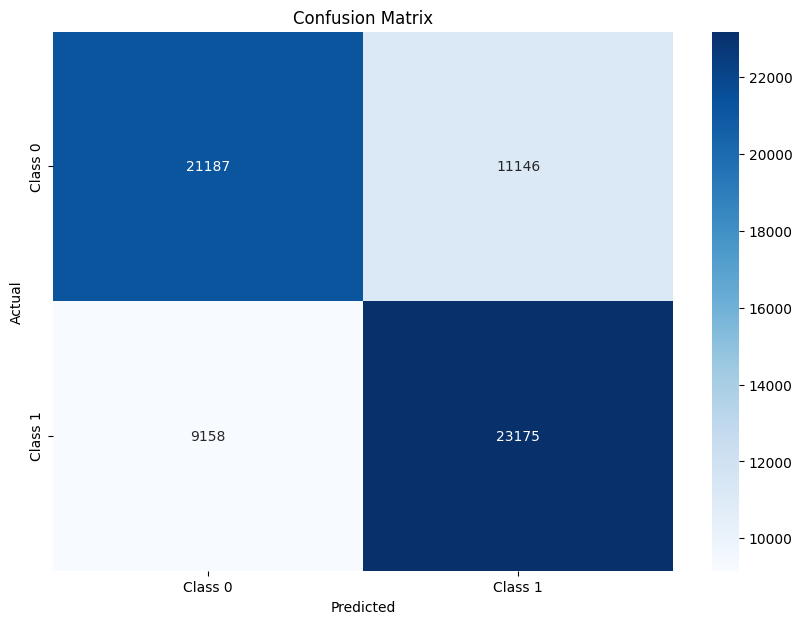

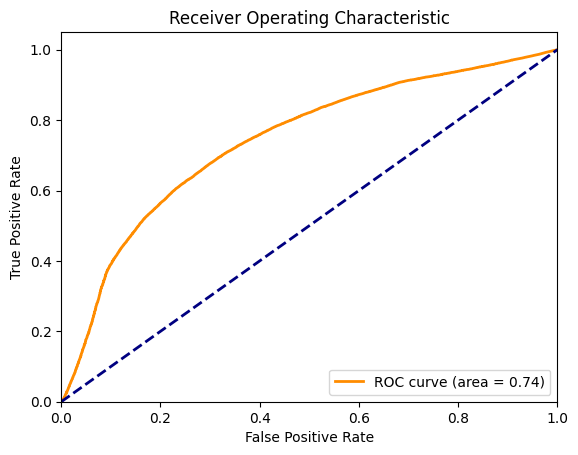

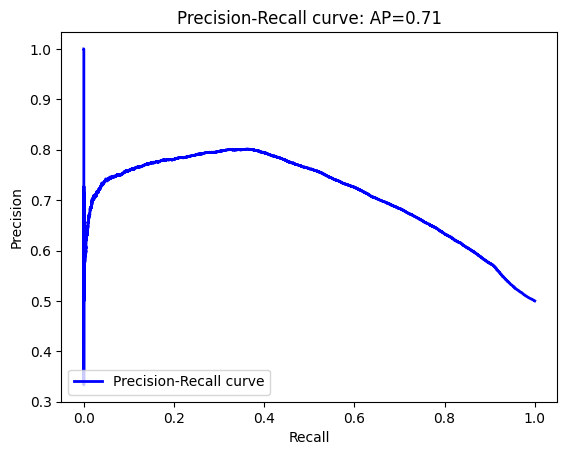

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# Print classification report
print("Classification Report:")
print(classification_report(all_labels.cpu(), predicted.cpu(), target_names=['Class 0', 'Class 1']))

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels.cpu(), predicted.cpu())
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Compute and plot ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels.cpu(), all_outputs[:, 1].cpu())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Compute and plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(all_labels.cpu(), all_outputs[:, 1].cpu())
average_precision = average_precision_score(all_labels.cpu(), all_outputs[:, 1].cpu())
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve: AP={average_precision:0.2f}')
plt.legend(loc="lower left")
plt.show()
